# Doc2Vec

This notebook attempts to use LDA to model the topics in a group of Bugzilla bugs through text analysis.

Also want to use [this approach](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) to use grid search to determine the most meaningful number of topics that exist in the text.

# Google Colaborator Setup

This section contains cells to set up the Google Colaborator environment to run this notebook. The following are needed:

* Clone the Github repository
* Install Spacy
* Install pyLDAVis

## Note: The runtime may need to be restarted after installing Spacy.

In [1]:
!pip install spacy

In [2]:
!python -m spacy download en_core_web_sm


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [3]:
!git clone https://github.com/HSV-AI/bug-analysis.git
%cd bug-analysis

Cloning into 'bug-analysis'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 71 (delta 4), reused 5 (delta 1), pack-reused 58
Unpacking objects: 100% (71/71), done.
/content/bug-analysis


# Loading Bugzilla Data

In [4]:
%run LoadData.ipynb

Loaded 2000 bugs
Created DataFrame named df
['id', 'title', 'component', 'product', 'text', 'reporter', 'commenters']


In [0]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

Now let's take a look at the content of the bugs that we retrieved.

First we can check the distribution of bugs across the defined components:

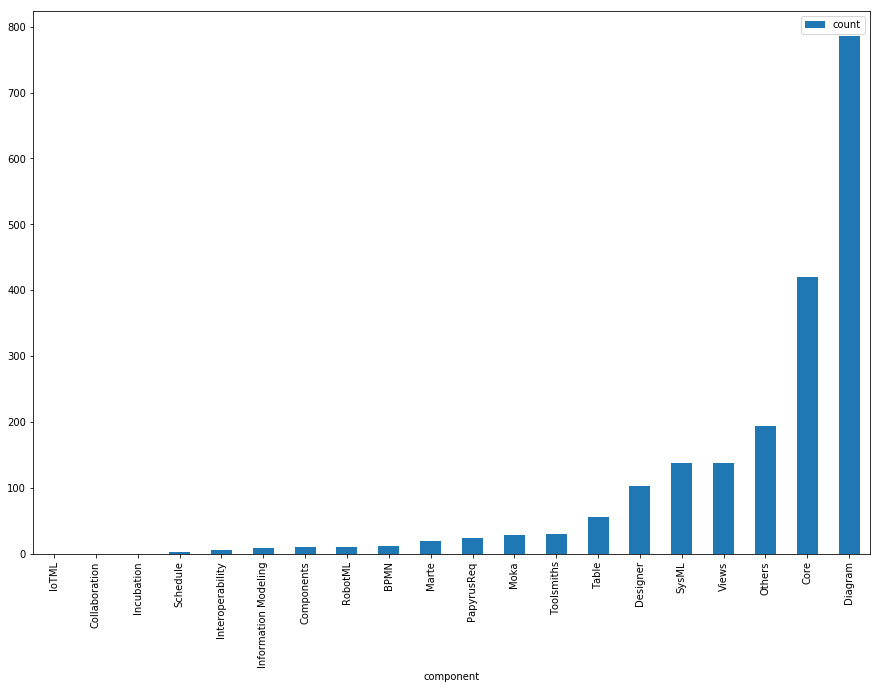

In [6]:
grouped = df.loc[:,['id','component']].groupby('component').count()
grouped.columns = ['count']
grouped.sort_values(by='count').plot(kind='bar', figsize=(15,10))
plt.show()

# Cleaning Data

If you have ever worked with software bugs, you know that many of them are lacking enough information to be useful. On the other hand, some will take on a life of their own and change direction over time.

In this analysis, we will try to remove the bugs that have little text as well as those that have an overwhelming length of text.

We start by showing the distribution of the length, followed by calculation of the 3*sigma cuttof points. Seeing that this method will not work for this non-normal distribution, we use the Interquartile Range (IQR) instead.

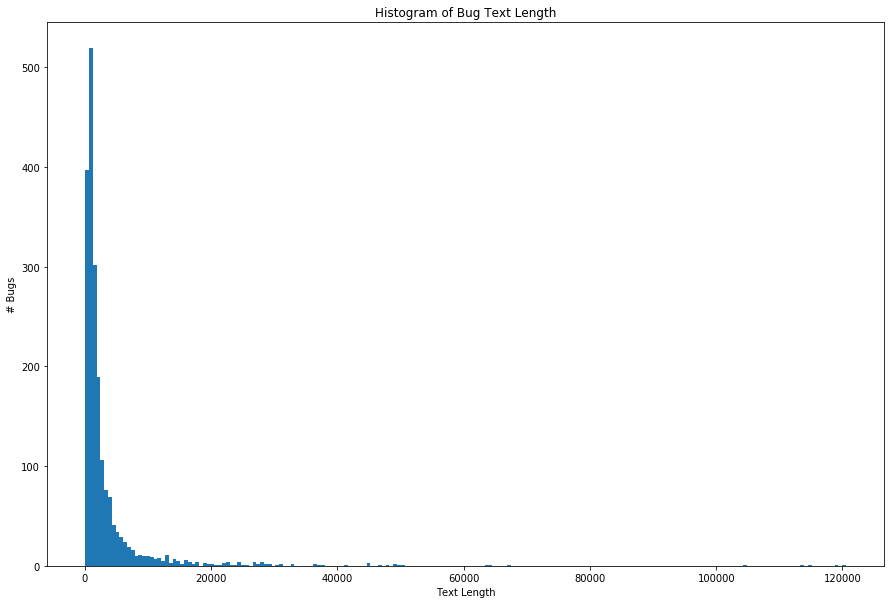

Min/Max length of any bug is 34/120563

Mean of text length is 3532
 
Standard Deviation of the text length is 8250

3 Sigma cuttoff values are lower: -21218 and upper: 28283

Interquartile Range is 2215

IQR cuttoff values are lower: -2585 and upper: 6275



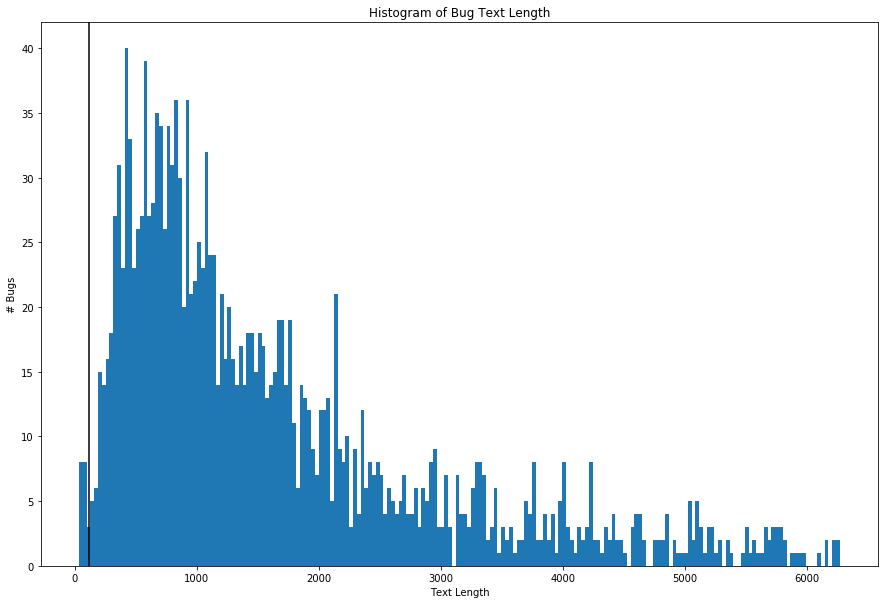

Using a manually defined lower value of 120 (See Vertical Black Line Above)

The resulting set contains 1750 bugs



In [7]:
df['length'] = df['text'].str.len()
text_arr = df.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.hist(text_arr, bins=200)
plt.show()

print('Min/Max length of any bug is %d/%d\n'%(np.min(text_arr), np.max(text_arr)))

# Find the values bounding the 98 percentile
# May want to filter these later
mean = np.mean(text_arr)
print('Mean of text length is %d\n ' % mean)
stdev = np.std(text_arr)
print('Standard Deviation of the text length is %d\n' % stdev)
#Compute 3sigma
sigma = 3*stdev
lower = mean - sigma
upper = mean + sigma

print('3 Sigma cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

q25, q75 = np.percentile(text_arr, 25), np.percentile(text_arr, 75)
iqr = q75 - q25
print('Interquartile Range is %d\n' % iqr)

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print('IQR cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]

# Let's get a look at these values
text_arr = trimmedDF.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.axvline(x=120, color='k')
plt.hist(text_arr, bins=200)
plt.show()

print("Using a manually defined lower value of 120 (See Vertical Black Line Above)\n")
lower = 120
trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]
text_arr = trimmedDF.loc[:,'length'].values
print('The resulting set contains %d bugs\n' % len(text_arr))

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [0]:
nlp = spacy.load("en_core_web_sm")

exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

filter = ['VERB', 'NOUN', 'PROPN']

def tokenize(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if re.fullmatch('[a-zA-Z]+', token.text):
#            if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                filtered_tokens.append(token.lemma_)
    return filtered_tokens



Let's run this tokenizer across all of our text and see how many words we have.

In [9]:
# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0

for i in trimmedDF.loc[:,'text']:
#     count = count+1
    allwords = tokenize(i)
    totalvocab.extend(allwords)
# #     if count > 20:
#         break
print('Total word count: '+str(len(totalvocab)))
print('Total unique words: '+str(len(set(totalvocab))))

Total word count: 378728
Total unique words: 6455


# Doc2Vec

Reference: https://markroxor.github.io/gensim/static/notebooks/doc2vec-IMDB.html



In [19]:
import multiprocessing
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from gensim.models.doc2vec import TaggedDocument

cores = multiprocessing.cpu_count()
print(cores)
print(gensim.models.doc2vec.FAST_VERSION)

2
1


In [0]:
def read_corpus():
  for i, row in trimmedDF.iterrows():
    yield TaggedDocument(tokenize(row['text']), [row['id']])

train_corpus = list(read_corpus())

In [0]:
# Defaults dm=1, dm_concat=0, dm_tag_count=1, vector_size=100, seed=1, hashfxn=<built-in function hash>, window=5
# Defaults documents=None, corpus_file=None, dm_mean=None, dm=1, dbow_words=0, dm_concat=0, dm_tag_count=1, docvecs=None, docvecs_mapfile=None, comment=None, trim_rule=None
model = Doc2Vec(dm=1, vector_size=50, min_count=2, epochs=40, workers=cores)


In [0]:
model.build_vocab(train_corpus)

In [24]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 38.6 s, sys: 720 ms, total: 39.3 s
Wall time: 21 s


In [25]:
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]
text = trimmedDF.loc[trimmedDF['id'] == doc.tags[0]].iloc[0]['text']
print(doc.tags[0],text)

inferred_vector = model.infer_vector(doc.words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print()
text = trimmedDF.loc[trimmedDF['id'] == sims[1][0]].iloc[0]['text']
print(sims[1][0],text)


348542 [All Diagrams] Re-target a comment or constraint link does not remove inconsistent occurrence Such link cannot be created twice, meaning that if the element is already in the feature list (ex: annotated elements) the link cannot be created, but with re-orient it is possible to obtain a situation where several occurrence exists (it should be possible due to multi-diagram anyway).

In such a case, destroy the link, re-orienting, or modifying the related feature in preferences should result in the destruction of all inconsistent links. It is still possible to create inconsistencies between graphic and model in current 0.10.X version. Behavior is not specific to SysML and can be produced with a class diagram as well.

Steps to reproduce
- Create a comment and two classes. Add a link from the comment to each class => annotated elements list contains both classes
- Now re-target one of the links to the first class => annotated elements list contains only the first class
- Now undo the

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# Visualize the Results

This section uses several methods to visualize the results of the LDA.

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

In [27]:
!pip install MulticoreTSNE

  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


In [0]:
# Creating and fitting the tsne model to the document embeddings
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(model.docvecs.vectors_docs)

# Putting the tsne information into sq
tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])
# tsne_tfidf_df.columns = ["x", "y"]
tsne_d2v_df["qid"] = trimmedDF["id"].values
tsne_d2v_df["question_text"] = trimmedDF["text"].values
tsne_d2v_df["target"] = 1

In [29]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

output_notebook()
plot_d2v = bp.figure(plot_width = 800, plot_height = 700, 
                       title = "T-SNE applied to Doc2vec document embeddings",
                       tools = "pan, wheel_zoom, box_zoom, reset, hover, previewsave",
                       x_axis_type = None, y_axis_type = None, min_border = 1)

# colormap = np.array(["#6d8dca", "#d07d3c"])
colormap = np.array(["darkblue", "darkblue"])

# palette = d3["Category10"][len(tsne_tfidf_df["asset_name"].unique())]
source = ColumnDataSource(data = dict(x = tsne_d2v_df["x"], 
                                      y = tsne_d2v_df["y"],
                                      color = colormap[tsne_d2v_df["target"]],
                                      question_text = tsne_d2v_df["question_text"],
                                      qid = tsne_d2v_df["qid"],
                                      target = tsne_d2v_df["target"]))

plot_d2v.scatter(x = "x", 
                   y = "y", 
                   color="color",
                   legend = "target",
                   source = source,
                   alpha = 0.7)
hover = plot_d2v.select(dict(type = HoverTool))
hover.tooltips = {"qid": "@qid", 
                  "question_text": "@question_text", 
                  "target":"@target"}

show(plot_d2v)

Loading BokehJS ...

## Now in 3D!

In [0]:
# Creating and fitting the tsne model to the document embeddings
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=3,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d3v = tsne_model.fit_transform(model.docvecs.vectors_docs)

# Putting the tsne information into sq
tsne_d3v_df = pd.DataFrame(data=tsne_d3v, columns=["x", "y", "z"])
# tsne_tfidf_df.columns = ["x", "y"]
tsne_d3v_df["qid"] = trimmedDF["id"].values
tsne_d3v_df["question_text"] = trimmedDF["text"].values
tsne_d3v_df["target"] = 1

In [46]:
from IPython.display import IFrame
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=tsne_d3v[:,0],
    y=tsne_d3v[:,1],
    z=tsne_d3v[:,2],
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

plotly.offline.plot({
        "data": data,
        "layout": layout
    })

import IPython
IPython.display.HTML(filename='/content/bug-analysis/temp-plot.html')